In [1]:
from lib.training_utils import read_config
from run.default_configuration import get_default_configuration
import warnings
import os

warnings.filterwarnings("ignore")

fold = 0
folder_name = 'fold_' + str(fold)
weight_folder = 'binary'

config = read_config('adversarial_acdc.yaml', False, False)

plans_file, output_folder_name, dataset_directory, batch_dice, stage, \
        trainer_class = get_default_configuration('2d', 'Task031_ACDC', 'nnMTLTrainerV2', config, 'custom_experiment_planner')

trainer = trainer_class(plans_file, fold, output_folder=weight_folder, dataset_directory=dataset_directory,
                            batch_dice=batch_dice, stage=stage, unpack_data=True, middle=False, video=False,
                            deterministic=True,
                            fp16=True, inference=True, binary=True)

trainer.load_final_checkpoint(train=False)

trainer.network.eval()

trainer.validate(save_softmax=False,
                run_postprocessing_on_folds=True,
                overwrite=False, 
                output_folder=os.path.join(r'rubbish', folder_name),
                debug=True)

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnMTLTrainerV2.nnMTLTrainerV2'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'noNorm'}
use_mask_for_norm OrderedDict([(0, False)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'noNorm')])
stages...

stage:  0
{'batch_size': 2, 'num_pool_per_axis': [3, 3], 'patch_size': array([224, 224]), 'median_patient_size_in_voxels': array([  9, 249, 219]), 'current_spacing': array([10.        ,  1.48438001,  1.48438001]), 'original_spacing': array([10.        ,  1.48438001,  1.48438001]), 'pool_op_kernel_sizes': [[2, 2], [2, 2], [2, 2]], 'conv_kernel_sizes': [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3]], 'do_dummy_2D_data_aug': False}

I am using stage 0 from these plans
I am using batch dice + CE loss

I am using data fro

In [34]:
import numpy as np

arr = np.array([1, 5, 9, 5, 25, 4, 3])
print(arr[:-2] - 2* arr[1:-1] + arr[2:])
print(np.diff(arr, 2))
print(np.gradient(np.gradient(arr)))

[  0  -8  24 -41  20]
[  0  -8  24 -41  20]
[ 0.   -2.    2.   -0.25 -9.5  -0.25 10.  ]


In [10]:
%matplotlib qt

import nibabel as nib
from glob import glob
import numpy as np
from skimage.measure import perimeter
import matplotlib.pyplot as plt

data = nib.load(r'custom_lib_t\patient001\patient001_slice05_gt.nii.gz')
arr = data.get_fdata()

fig, ax = plt.subplots(1, 1)
ax.imshow(arr[:, :, 0], cmap='gray')
plt.show()

Compute strain

In [11]:
import nibabel as nib
import numpy as np
import cv2 as cv

data = nib.load(r'custom_lib_t\patient001\patient001_slice05_gt.nii.gz')
arr = data.get_fdata()

for i in range(arr.shape[-1]):
    current_arr = arr[:, :, i]
    binarized_rv = current_arr == 1
    binarized_endo = current_arr == 3
    binarized_epi = np.logical_or(current_arr == 2, binarized_endo)
    perim_rv = perimeter(binarized_rv)
    perim_endo = perimeter(binarized_endo)
    perim_epi = perimeter(binarized_epi)

(512, 512, 40)


AttributeError: 'tuple' object has no attribute 'shape'

In [5]:
%matplotlib qt

import nibabel as nib
from glob import glob
import numpy as np
from skimage.measure import perimeter
import matplotlib.pyplot as plt

depth = 3

path_list_1 = glob(r'2023-07-04_18H12\Registered\validation_raw\patient014*')
path_list_2 = glob(r'2023-07-06_15H24\Registered\validation_raw\patient014*')
path_list_3 = glob(r'2023-07-06_15H41\Registered\validation_raw\patient014*')

list_of_path_list = [path_list_1, path_list_2, path_list_3]

data_dict_list = [{'rv_perim': [], 'endo_perim': [], 'epi_perim': [], 'rv_strain': None, 'lv_strain': None} for i in range(len(list_of_path_list))]
for idx, path_list in enumerate(list_of_path_list):
    for path in path_list:
        data = nib.load(path)
        arr = data.get_fdata()
        current_arr = arr[:, :, depth]
        binarized_rv = current_arr == 1
        binarized_endo = current_arr == 3
        binarized_epi = np.logical_or(current_arr == 2, binarized_endo)
        perim_rv = perimeter(binarized_rv)
        perim_endo = perimeter(binarized_endo)
        perim_epi = perimeter(binarized_epi)
        data_dict_list[idx]['rv_perim'].append(perim_rv)
        data_dict_list[idx]['endo_perim'].append(perim_endo)
        data_dict_list[idx]['epi_perim'].append(perim_epi)

    rv_strain = [(data_dict_list[idx]['rv_perim'][i] - data_dict_list[idx]['rv_perim'][0]) / data_dict_list[idx]['rv_perim'][0] for i in range(len(data_dict_list[idx]['rv_perim']))]
    endo_strain = [(data_dict_list[idx]['endo_perim'][i] - data_dict_list[idx]['endo_perim'][0]) / data_dict_list[idx]['endo_perim'][0] for i in range(len(data_dict_list[idx]['endo_perim']))]
    epi_strain = [(data_dict_list[idx]['epi_perim'][i] - data_dict_list[idx]['epi_perim'][0]) / data_dict_list[idx]['epi_perim'][0] for i in range(len(data_dict_list[idx]['epi_perim']))]

    rv_strain = np.array(rv_strain)
    endo_strain = np.array(endo_strain)
    epi_strain = np.array(epi_strain)

    data_dict_list[idx]['rv_strain'] = rv_strain
    data_dict_list[idx]['lv_strain'] = (endo_strain + epi_strain) / 2


fig, ax = plt.subplots(1, 1)
X = np.arange(len(path_list_1))
for i in range(len(list_of_path_list)):
    strain = data_dict_list[i]['lv_strain']
    #second_order_derivative = np.abs(strain[:-2] - 2* strain[1:-1] + strain[2:])
    #second_order_derivative = np.pad(second_order_derivative, pad_width=(1, 1))
    #ax.plot(X, second_order_derivative, label='second derivative' + str(i))
    ax.plot(X, strain, label='LV' + str(i))
ax.set_xlim(left=0)
ax.legend()

In [2]:
%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt

data = np.load(r'data_ok_original_2\Original\RACINE_BP04001_20121218\RACINE_BP04001_20121218_Slice_08_short_axis.npz')
label = data['label_img']

plt.imshow(label[15], cmap='gray')

In [7]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\infer_1_lib_input\patient001\patient001.csv")
df['ed_index'][0]

0

In [11]:
%matplotlib qt

import nibabel as nib
from glob import glob
import numpy as np
from skimage.measure import perimeter
import matplotlib.pyplot as plt

depth = 3

path_list_1 = glob(r'2023-07-03_20H48\fold_0\Registered\validation_raw\patient014*')
path_list_2 = glob(r'2023-07-03_20H55\fold_0\Registered\validation_raw\patient014*')
path_list_3 = glob(r'2023-07-03_21H14\fold_0\Registered\validation_raw\patient014*')
path_list_4 = glob(r'2023-07-03_21H44\fold_0\Registered\validation_raw\patient014*')

path_list_5 = glob(r'2023-07-04_18H05\Registered\validation_raw\patient014*')
path_list_6 = glob(r'2023-07-04_18H12\Registered\validation_raw\patient014*')
path_list_7 = glob(r'2023-07-04_18H05\Segmentation\validation_raw\patient014*')
path_list_8 = glob(r'2023-07-04_18H12\Segmentation\validation_raw\patient014*')

list_of_path_list = [path_list_6]

data_dict_list = [{'rv_perim': [], 'endo_perim': [], 'epi_perim': [], 'rv_strain': None, 'lv_strain': None} for i in range(len(list_of_path_list))]
for idx, path_list in enumerate(list_of_path_list):
    for path in path_list:
        data = nib.load(path)
        arr = data.get_fdata()
        current_arr = arr[:, :, depth]
        binarized_rv = current_arr == 1
        binarized_endo = current_arr == 3
        binarized_epi = np.logical_or(current_arr == 2, binarized_endo)
        perim_rv = perimeter(binarized_rv)
        perim_endo = perimeter(binarized_endo)
        perim_epi = perimeter(binarized_epi)
        data_dict_list[idx]['rv_perim'].append(perim_rv)
        data_dict_list[idx]['endo_perim'].append(perim_endo)
        data_dict_list[idx]['epi_perim'].append(perim_epi)

    rv_strain = [(data_dict_list[idx]['rv_perim'][i] - data_dict_list[idx]['rv_perim'][0]) / data_dict_list[idx]['rv_perim'][0] for i in range(len(data_dict_list[idx]['rv_perim']))]
    endo_strain = [(data_dict_list[idx]['endo_perim'][i] - data_dict_list[idx]['endo_perim'][0]) / data_dict_list[idx]['endo_perim'][0] for i in range(len(data_dict_list[idx]['endo_perim']))]
    epi_strain = [(data_dict_list[idx]['epi_perim'][i] - data_dict_list[idx]['epi_perim'][0]) / data_dict_list[idx]['epi_perim'][0] for i in range(len(data_dict_list[idx]['epi_perim']))]

    rv_strain_2 = [(data_dict_list[idx]['rv_perim'][i] - data_dict_list[idx]['rv_perim'][0]) for i in range(len(data_dict_list[idx]['rv_perim']))]
    endo_strain_2 = [(data_dict_list[idx]['endo_perim'][i] - data_dict_list[idx]['endo_perim'][0]) for i in range(len(data_dict_list[idx]['endo_perim']))]
    epi_strain_2 = [(data_dict_list[idx]['epi_perim'][i] - data_dict_list[idx]['epi_perim'][0]) for i in range(len(data_dict_list[idx]['epi_perim']))]

    sum_rv = np.array(data_dict_list[idx]['rv_perim']).sum()
    sum_endo = np.array(data_dict_list[idx]['endo_perim']).sum()
    sum_epi = np.array(data_dict_list[idx]['epi_perim']).sum()

    rv_strain_3 = [(data_dict_list[idx]['rv_perim'][i] - data_dict_list[idx]['rv_perim'][0]) / sum_rv for i in range(len(data_dict_list[idx]['rv_perim']))]
    endo_strain_3 = [(data_dict_list[idx]['endo_perim'][i] - data_dict_list[idx]['endo_perim'][0]) / sum_endo for i in range(len(data_dict_list[idx]['endo_perim']))]
    epi_strain_3 = [(data_dict_list[idx]['epi_perim'][i] - data_dict_list[idx]['epi_perim'][0]) / sum_epi for i in range(len(data_dict_list[idx]['epi_perim']))]

    rv_strain = np.array(rv_strain)
    endo_strain = np.array(endo_strain)
    epi_strain = np.array(epi_strain)

    rv_strain_2 = np.array(rv_strain_2)
    endo_strain_2 = np.array(endo_strain_2)
    epi_strain_2 = np.array(epi_strain_2)

    rv_strain_3 = np.array(rv_strain_3)
    endo_strain_3 = np.array(endo_strain_3)
    epi_strain_3 = np.array(epi_strain_3)

    data_dict_list[idx]['rv_strain'] = rv_strain
    data_dict_list[idx]['lv_strain'] = (endo_strain + epi_strain) / 2

    data_dict_list[idx]['rv_strain_2'] = rv_strain_2
    data_dict_list[idx]['lv_strain_2'] = (endo_strain_2 + epi_strain_2) / 2

    data_dict_list[idx]['rv_strain_3'] = rv_strain_3
    data_dict_list[idx]['lv_strain_3'] = (endo_strain_3 + epi_strain_3) / 2

fig_1, ax_1 = plt.subplots(1, 1)
X = np.arange(len(path_list_1))
strain = data_dict_list[i]['lv_strain']

second_order_derivative = np.abs(strain[:-2] - 2* strain[1:-1] + strain[2:])
second_order_derivative = np.pad(second_order_derivative, pad_width=(1, 1))

ax_1.plot(X, second_order_derivative, label='second derivative')
ax_1.plot(X, strain, label='LV')

ax_1.set_xlim(left=0)
ax_1.legend()


fig_2, ax_2 = plt.subplots(1, 1)
X = np.arange(len(path_list_1))
strain_2 = data_dict_list[i]['lv_strain_2']

second_order_derivative_2 = np.abs(strain_2[:-2] - 2* strain_2[1:-1] + strain_2[2:])
second_order_derivative_2 = np.pad(second_order_derivative_2, pad_width=(1, 1))

ax_2.plot(X, second_order_derivative_2, label='second derivative 2')
ax_2.plot(X, strain_2, label='LV 2')
ax_2.set_xlim(left=0)
ax_2.legend()


fig_3, ax_3 = plt.subplots(1, 1)
X = np.arange(len(path_list_1))
strain_3 = data_dict_list[i]['lv_strain_3']

second_order_derivative_3 = np.abs(strain_3[:-2] - 2* strain_3[1:-1] + strain_3[2:])
second_order_derivative_3 = np.pad(second_order_derivative_3, pad_width=(1, 1))

ax_3.plot(X, second_order_derivative_3, label='second derivative 3')
ax_3.plot(X, strain_3, label='LV 3')
ax_3.set_xlim(left=0)
ax_3.legend()


#fig, ax = plt.subplots(1, 1)
#X = np.arange(len(path_list_1))
#for i in range(len(list_of_path_list)):
#    strain = data_dict_list[i]['lv_strain']
#    second_order_derivative = np.abs(strain[:-2] - 2* strain[1:-1] + strain[2:])
#    second_order_derivative = np.pad(second_order_derivative, pad_width=(1, 1))
#    ax.plot(X, second_order_derivative, label='second derivative' + str(i))
#    ax.plot(X, strain, label='LV' + str(i))
#ax.set_xlim(left=0)
#ax.legend()

In [3]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt

depth = 2

data_3t = nib.load(r'custom_quorum\patient026\patient026_ed.nii.gz')
arr_3t = data_3t.get_fdata()

data_15t = nib.load(r'custom_quorum\patient001\patient001_ed.nii.gz')
arr_15t = data_15t.get_fdata()

fig, ax = plt.subplots(1, 2)
ax[0].imshow(arr_3t[:, :, depth], cmap='gray')
ax[1].imshow(arr_15t[:, :, depth], cmap='gray')
plt.show()

In [5]:
import torch

t = torch.randn(size=(2, 256, 512))
out = t.chunk(2)
print(len(out))
print(type(out))
print(out[0].shape)

t1 = torch.arange(5)
t2 = torch.arange(5, 10)
t = torch.cat([t1[None], t2[None]], dim=0)
print(t.chunk(2)[::-1])

2
<class 'tuple'>
torch.Size([1, 256, 512])
(tensor([[5, 6, 7, 8, 9]]), tensor([[0, 1, 2, 3, 4]]))


In [1]:
import torch

t = torch.arange(0, 10)
t.unfold(0, 2, 1)

tensor([[0, 1],
        [1, 2],
        [2, 3],
        [3, 4],
        [4, 5],
        [5, 6],
        [6, 7],
        [7, 8],
        [8, 9]])

In [14]:
%matplotlib qt

from monai.transforms import KeepLargestConnectedComponent
import nibabel as nib
import matplotlib.pyplot as plt

data = nib.load(r'rubbish\fold_0\validation_raw\patient089_frame01.nii.gz')
arr = data.get_fdata()

depth = 5

out = KeepLargestConnectedComponent(applied_labels=[1])(arr[:, :, depth][None])
print(out.shape)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(arr[:, :, depth], cmap='gray')
ax[1].imshow(out[0], cmap='gray')
plt.show()

(1, 264, 288)


In [6]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt

data = nib.load(r'ACDC_output\Folds\all_data\fold_0\validation_raw\patient005_frame01.nii.gz')
arr = data.get_fdata()

fig, ax = plt.subplots(1, 1)
ax.imshow(arr[:, :, 4], cmap='gray')
plt.show()

In [9]:
%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

data = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task031_ACDC\imagesTr\patient082_frame17_u_0000.nii.gz')
arr = data.get_fdata()
print(arr.shape)

fig, ax = plt.subplots(1, 1)
ax.imshow(arr[:, :, 1], cmap='gray')
plt.show()

(224, 154, 16)


In [1]:
%matplotlib qt

from lib.training_utils import read_config
from run.default_configuration import get_default_configuration
import warnings
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

fold = 0
folder_name = 'fold_' + str(fold)
weight_folder = os.path.join(r'C:\Users\Portal\Documents\ACDC_output_old\Baseline', folder_name)
#weight_folder = r'2023-05-06_18H51'

config = read_config('adversarial_acdc.yaml', False, False)

plans_file, output_folder_name, dataset_directory, batch_dice, stage, \
        trainer_class = get_default_configuration('2d', 'Task027_ACDC', 'nnMTLTrainerV2', config, 'custom_experiment_planner')

trainer = trainer_class(plans_file, 0, output_folder=weight_folder, dataset_directory=dataset_directory,
                            batch_dice=batch_dice, stage=stage, unpack_data=True, middle=False, video=False,
                            deterministic=True, config=config,
                            fp16=True)

trainer.load_final_checkpoint(train=False)

trainer.network.eval()

trainer.validate(save_softmax=False,
                run_postprocessing_on_folds=True,
                overwrite=False, 
                output_folder=os.path.join(r'rubbish', folder_name),
                debug=True)

#data = np.load(r'out\nnUNet_preprocessed\Task027_ACDC\custom_experiment_planner_stage0\patient017_frame01.npy')
#
#fig, ax = plt.subplots(1, 1)
#ax.imshow(data[0, int(data.shape[1] * 0.25)], cmap='gray')
#plt.waitforbuttonpress()
#plt.show()
#print(data.shape)
#out = trainer.predict_preprocessed_data_return_seg_and_softmax(data[:-1, int(data.shape[1] * 0.25)][None],
#                                                            do_mirroring=False,
#                                                            mirror_axes=(),
#                                                            use_sliding_window=True,
#                                                            step_size=0.5,
#                                                            use_gaussian=True,
#                                                            all_in_gpu=False,
#                                                            mixed_precision=False,
#                                                            get_flops=False,
#                                                            binary=False)[1]
#print(out.shape)

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnMTLTrainerV2.nnMTLTrainerV2'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, False)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 1, 'num_pool_per_axis': [3, 3], 'patch_size': array([224, 224]), 'median_patient_size_in_voxels': array([  9, 249, 219]), 'current_spacing': array([10.        ,  1.48438001,  1.48438001]), 'original_spacing': array([10.        ,  1.48438001,  1.48438001]), 'pool_op_kernel_sizes': [[2, 2], [2, 2], [2, 2]], 'conv_kernel_sizes': [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3]], 'do_dummy_2D_data_aug': False}

I am using stage 0 from these plans
I am using batch dice + CE loss

I am using data from th

KeyboardInterrupt: 

In [3]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt

data = nib.load(r'rubbish\fold_0\validation_raw\patient005_frame01.nii.gz')
arr = data.get_fdata()
print(arr.shape)

data2 = nib.load(r'rubbish\fold_0\temp_allClasses\patient005_frame01.nii.gz')
arr2 = data2.get_fdata()
print(arr2.shape)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(arr[:, :, 5], cmap='gray')
ax[1].imshow(arr2[:, :, 5], cmap='gray')
plt.show()

(256, 216, 10)
(256, 216, 10)


In [29]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt

ed_data = nib.load(r'ACDC_training\patient048\patient048_frame01_gt.nii.gz')
ed_arr = ed_data.get_fdata()

es_data = nib.load(r'ACDC_training\patient048\patient048_frame08_gt.nii.gz')
es_arr = es_data.get_fdata()

fig, ax = plt.subplots(1, 2)
ax[0].imshow(ed_arr[:, :, 5], cmap='gray')
ax[1].imshow(es_arr[:, :, 5], cmap='gray')

In [1]:
from glob import glob
import numpy as np
import nibabel as nib
from tqdm import tqdm
import pickle 

path_list = glob(r'ACDC_training\**\*_gt.nii.gz')
path_list = sorted(path_list)
total = 0
valid = 0
out_dict = {}
for i in range(0, len(path_list), 2):
    ed_path = path_list[i]
    es_path = path_list[i + 1]
    patient_name = ed_path.split('\\')[-2]
    out_dict[patient_name] = []
    ed_data = nib.load(ed_path)
    ed_arr = ed_data.get_fdata()
    es_data = nib.load(es_path)
    es_arr = es_data.get_fdata()
    for j in range(ed_arr.shape[-1]):
        total += 1
        current_ed = ed_arr[:, :, j]
        current_es = es_arr[:, :, j]
        if len(np.unique(current_ed)) == len(np.unique(current_es)):
            out_dict[patient_name].append(j)
            valid += 1
print(valid / total)
print(out_dict)
with open('valid_sequence.pkl', 'wb') as f:
    pickle.dump(out_dict, f)

0.8065194532071503
{'patient001': [0, 2, 3, 4, 5, 6, 7], 'patient002': [1, 2, 3, 4, 5, 6, 7, 9], 'patient003': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'patient004': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'patient005': [0, 2, 3, 4, 5, 6, 7, 8], 'patient006': [0, 1, 3, 4, 5, 6, 7, 8, 9], 'patient007': [0, 2, 3, 4, 5, 6, 7, 8, 9], 'patient008': [1, 2, 3, 4, 5, 6, 8, 9], 'patient009': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'patient010': [1, 2, 3, 4, 5, 6, 7, 8], 'patient011': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'patient012': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'patient013': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'patient014': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'patient015': [0, 1, 2, 3, 4, 5, 6, 7], 'patient016': [1, 2, 3, 4, 5, 6, 7, 8], 'patient017': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'patient018': [0, 1, 2, 3, 4, 5, 6], 'patient019': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'patient020': [0, 1, 2, 3, 4, 5, 6, 7], 'patient021': [2, 3, 4, 5, 6], 'patient022': [0, 1, 2, 4, 5, 6], 'patient023': [0, 1, 2, 3, 4, 5, 6, 8], 'patient024': [0, 1, 2, 3, 4, 5],

In [10]:
%matplotlib qt

from monai.transforms import LabelToContour
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

data_img = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task027_ACDC\imagesTr\patient005_frame01_0000.nii.gz')
arr_img = data_img.get_fdata()
arr_img = np.transpose(arr_img, (2, 0, 1))
out_arr = []
for i in range(len(arr_img)):
    out = cv.normalize(arr_img[i], None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
    out = cv.cvtColor(out, cv.COLOR_GRAY2RGB)
    out_arr.append(out)
out_arr = np.stack(out_arr, axis=0)
print(out_arr.shape)

label_to_contour_obj = LabelToContour()
data_pred = nib.load(r'ACDC_output\Baseline\temp_perClass\patient005_frame01.nii.gz')
arr_pred = data_pred.get_fdata()
arr_pred = np.transpose(arr_pred, (2, 0, 1))

contour_list = []
for i in range(len(arr_pred)):
    for j in range(1, 4):
        seg = (arr_pred[i] == j).astype(np.uint8)
        contours, hierarchy = cv.findContours(seg, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        color = [0, 0, 0]
        color[j - 1] = 255
        cv.drawContours(out_arr[i], contours, -1, color, 1)

fig, ax = plt.subplots(1, 1)
ax.imshow(out_arr[2, :, :], cmap='gray')

(10, 256, 216, 3)


In [14]:
True | False

True

In [8]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt
from glob import glob
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
import matplotlib as mpl


depth = 2

data_es = nib.load(r'ACDC_training\patient005\patient005_frame13_gt.nii.gz')
arr_es = data_es.get_fdata()

path_list = glob(r"2023-08-20_18H11\fold_0\Registered_local\validation_raw\patient005_frame*")
path_list.append("ACDC_training\patient005\patient005_frame01_gt.nii.gz")
path_list = sorted(path_list, key=lambda x:int(x.split('\\')[-1].split('frame')[-1][:2]))

indices = [int(x.split('\\')[-1].split('frame')[-1][:2]) - 1 for x in path_list]

data_2 = nib.load(r"ACDC_training\patient005\patient005_4d.nii.gz")
arr_2 = data_2.get_fdata()

image_list = []
fig, ax = plt.subplots(1, 3)
fig.tight_layout()
for path, idx in zip(path_list, indices):
    data_pred = nib.load(path)
    arr_pred = data_pred.get_fdata()
    current_pred = arr_pred[:, :, depth]
    current_img = arr_2[:, :, depth, idx]
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    im_0 = ax[0].imshow(current_pred, cmap='gray')
    im_1 = ax[1].imshow(current_img, cmap='gray')
    if idx == indices[0]:
        im_2 = ax[2].imshow(current_pred, cmap='gray')
    elif idx == indices[-1]:
        im_2 = ax[2].imshow(arr_es[:, :, depth], cmap='gray')
    else:
        im_2 = ax[2].imshow(np.random.randn(*arr_es[:, :, depth].shape), cmap='gray')
    image_list.append([im_0, im_1, im_2])
    #plt.show()
    #plt.waitforbuttonpress()
    #plt.close(fig)

ani = animation.ArtistAnimation(fig, image_list, interval=2500, blit=True, repeat_delay=10000)
#HTML(ani.to_jshtml())

# saving to m4 using ffmpeg writer
mpl.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Portal\\AppData\\Local\\Microsoft\\WinGet\\Packages\\Gyan.FFmpeg_Microsoft.Winget.Source_8wekyb3d8bbwe\\ffmpeg-6.0-full_build\\bin\\ffmpeg.exe"
writervideo = animation.FFMpegWriter(fps=60)
ani.save('deformation_4.mp4')

In [6]:
%matplotlib qt

from kornia.filters import spatial_gradient3d
import nibabel as nib
import torch
import matplotlib.pyplot as plt

data = nib.load(r'ACDC_training\patient001\patient001_4d.nii.gz')
arr = data.get_fdata()
img = arr
arr = torch.from_numpy(arr)
arr = arr[:, :, :, 0].permute(2, 0, 1).contiguous()[None, None]
print(arr.shape)

out = torch.abs(spatial_gradient3d(arr))
print(out.shape)
fig, ax = plt.subplots(1, 4)
ax[0].imshow(out[0, 0, 0, 0], cmap='gray')
ax[1].imshow(out[0, 0, 1, 0], cmap='gray')
ax[2].imshow(out[0, 0, 2, 0], cmap='gray')
ax[3].imshow(img[:, :, 0, 0], cmap='gray')
plt.show()

torch.Size([1, 1, 10, 216, 256])
torch.Size([1, 1, 3, 10, 216, 256])


In [21]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
vae.save_pretrained("vae_folder")
tokenizer.save_pretrained("tokenizer_folder")
text_encoder.save_pretrained("text_encoder_folder")

In [16]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

batch_size = 2

print(tokenizer.model_max_length)
print(text_encoder.config)

uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt"
)

uncond_embeddings = text_encoder(uncond_input.input_ids.to('cpu'))[0] 
print(uncond_embeddings.shape)

77
CLIPTextConfig {
  "_name_or_path": "openai/clip-vit-base-patch32",
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "dropout": 0.0,
  "eos_token_id": 2,
  "hidden_act": "quick_gelu",
  "hidden_size": 512,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 77,
  "model_type": "clip_text_model",
  "num_attention_heads": 8,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "projection_dim": 512,
  "transformers_version": "4.31.0",
  "vocab_size": 49408
}

torch.Size([2, 77, 512])


In [12]:
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
unet.config

FrozenDict([('sample_size', 64),
            ('in_channels', 4),
            ('out_channels', 4),
            ('center_input_sample', False),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2DCrossAttn'),
            ('up_block_types',
             ['UpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D']),
            ('only_cross_attention', False),
            ('block_out_channels', [320, 640, 1280, 1280]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attention_dim', 768),
            ('t

In [5]:
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, ControlNetModel
import torch
from diffusers import DDPMScheduler, DDPMPipeline, UNet2DModel, AutoencoderKL

unet = UNet2DModel()
controlnet = ControlNetModel().from_unet(unet)
controlnet.config

AttributeError: 'FrozenDict' object has no attribute 'only_cross_attention'

In [2]:
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet.config

c:\Users\Portal\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Portal\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


FrozenDict([('in_channels', 4),
            ('conditioning_channels', 3),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'DownBlock2D']),
            ('only_cross_attention', False),
            ('block_out_channels', [320, 640, 1280, 1280]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attention_dim', 768),
            ('transformer_layers_per_block', 1),
            ('encoder_hid_dim', None),
            ('encoder_hid_dim_type', None),
            ('attention_head_dim', 8),
            ('num_attention_heads', None),
            ('use_linear_projection', False),
            ('class_embed_type', None),
          

In [8]:
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.config

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


FrozenDict([('in_channels', 3),
            ('out_channels', 3),
            ('down_block_types',
             ['DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D']),
            ('up_block_types',
             ['UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D']),
            ('block_out_channels', [128, 256, 512, 512]),
            ('layers_per_block', 2),
            ('act_fn', 'silu'),
            ('latent_channels', 4),
            ('norm_num_groups', 32),
            ('sample_size', 512),
            ('_class_name', 'AutoencoderKL'),
            ('_diffusers_version', '0.6.0'),
            ('_name_or_path', 'CompVis/stable-diffusion-v1-4')])

In [3]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

data = nib.load(r'ACDC_training\patient001\patient001_frame01_gt.nii.gz')
arr = data.get_fdata()[:, :, 2]

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)

In [1]:
from lib.training_utils import read_config_video
from run.default_configuration import get_default_configuration
import warnings
import os
import sys
from pathlib import Path
from diffusers import UNet2DModel, ConfigMixin

warnings.filterwarnings("ignore")
fold = 0
weight_folder = '2023-08-09_11H57'

config = read_config_video(os.path.join(weight_folder, 'config.yaml'))

plans_file, output_folder_name, dataset_directory, batch_dice, stage, \
        trainer_class = get_default_configuration('2d', 'Task031_ACDC', 'nnMTLTrainerV2StableDiffusion', config, 'custom_experiment_planner')

trainer = trainer_class(plans_file, fold, output_folder=weight_folder, dataset_directory=dataset_directory,
                            batch_dice=batch_dice, stage=stage, unpack_data=True,
                            deterministic=True,
                            fp16=True, config=config)

#net = trainer.get_model()
#
net = UNet2DModel.from_pretrained(r'out\nnUNet_trained_models\nnUNet\2d\Task031_ACDC\nnMTLTrainerV2StableDiffusion__custom_experiment_planner\fold_0\2023-08-11_18H22')


###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnMTLTrainerV2Flow_StableDiffusion.nnMTLTrainerV2StableDiffusion'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'noNorm'}
use_mask_for_norm OrderedDict([(0, False)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'noNorm')])
stages...

stage:  0
{'batch_size': 10, 'num_pool_per_axis': [3, 3], 'patch_size': array([224, 224]), 'median_patient_size_in_voxels': array([  9, 249, 219]), 'current_spacing': array([10.        ,  1.48438001,  1.48438001]), 'original_spacing': array([10.        ,  1.48438001,  1.48438001]), 'pool_op_kernel_sizes': [[2, 2], [2, 2], [2, 2]], 'conv_kernel_sizes': [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3]], 'do_dummy_2D_data_aug': False}

I am using stage 0 from these plans
I am using batch

In [1]:
%matplotlib qt

from lib.training_utils import read_config_video
from run.default_configuration import get_default_configuration
import warnings
import os
import sys
from pathlib import Path

warnings.filterwarnings("ignore")
fold = 0
folder_name = 'fold_' + str(fold)

old_stdout = sys.stdout
filename = os.path.join(r'rubbish', folder_name, 'log_file')
os.makedirs(os.path.dirname(filename), exist_ok=True)
log_file = open(filename,"w")
sys.stdout = log_file

weight_folder = '2023-09-25_22H16'

config = read_config_video(os.path.join(weight_folder, 'config.yaml'))
config['inference_mode'] = 'one_step'
config['use_sfb'] = False

plans_file, output_folder_name, dataset_directory, batch_dice, stage, \
        trainer_class = get_default_configuration('2d', 'Task032_Lib', 'nnMTLTrainerV2FlowRecursiveVideo', config, 'custom_experiment_planner')

trainer = trainer_class(plans_file, fold, output_folder=weight_folder, dataset_directory=dataset_directory,
                            batch_dice=batch_dice, stage=stage, unpack_data=True,
                            deterministic=True,
                            fp16=True, config=config)

trainer.load_final_checkpoint(train=False)

trainer.network.eval()

trainer.validate(save_softmax=False,
                run_postprocessing_on_folds=True,
                overwrite=True, 
                output_folder=os.path.join(weight_folder, folder_name),
                debug=True)

sys.stdout = old_stdout
log_file.close()

100%|██████████| 55/55 [30:04<00:00, 32.81s/it]


In [3]:
import nibabel as nib

nib.load(r'')

torch.Size([9, 2])


In [14]:
import torch
# T_max, B, C, H, W

x1 = torch.rand(size=(28, 1, 256, 512))
norm = torch.linalg.norm(x1, dim=-1, keepdim=True)
print(norm.shape)
print((norm * norm).shape)

x = torch.matmul(x1, torch.transpose(x1, dim0=2, dim1=3)) / norm**2
print(x.shape)

torch.Size([28, 1, 256, 1])
torch.Size([28, 1, 256, 1])
torch.Size([28, 1, 256, 256])


In [5]:
l = []
extended = [3, 4, 5] * 1
l.extend(extended)
extended = [8, 8, 9] * 1
l.extend(extended)
print(l)

[3, 4, 5, 8, 8, 9]


In [10]:
import torch
import torch.nn as nn

x1 = torch.rand(size=(28, 1, 256, 512))
cos = nn.CosineSimilarity(dim=3, eps=1e-6)
output = cos(x1, x1)
print(output.shape)

torch.Size([28, 1, 256])


(128, 128, 3)
255


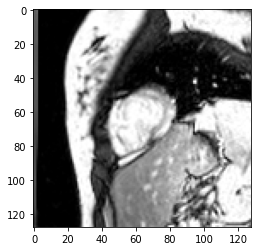

In [6]:
import cv2 as cv
import matplotlib.pyplot as plt

img = cv.imread(r'2023-08-08_18H49\Predictions\validation_raw\6DBDEA3129ED40C9938E.png')
print(img.shape)
print(img.max())
plt.imshow(img[:, :, 0], cmap='gray')

In [7]:
%matplotlib qt

import nibabel as nib
import torch
from kornia.filters import spatial_gradient3d, spatial_gradient
import matplotlib.pyplot as plt

data_1 = nib.load(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\rubbish\fold_0\validation_raw\patient005_frame01.nii.gz")
arr_1 = data_1.get_fdata()

data_2 = nib.load(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\rubbish_2\fold_0\validation_raw\patient005_frame01.nii.gz")
arr_2 = data_2.get_fdata()

print(arr_1.shape)
print(arr_2.shape)

#fig, ax = plt.subplots(arr_1.shape[-1], 2)
#for i in range(arr_1.shape[-1]):
#    ax[i, 0].imshow(arr_1[:, :, i], cmap='gray')
#    ax[i, 1].imshow(arr_2[:, :, i], cmap='gray')
#plt.show()
#while not plt.waitforbuttonpress(): pass
#plt.close(fig)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(arr_1[:, :, -1], cmap='gray')
ax[1].imshow(arr_2[:, :, -1], cmap='gray')
plt.show()
while not plt.waitforbuttonpress(): pass
plt.close(fig)

(256, 216, 10)
(256, 216, 10)


KeyboardInterrupt: 

In [10]:
%matplotlib qt

import nibabel as nib
import torch
from kornia.filters import spatial_gradient3d, spatial_gradient
import matplotlib.pyplot as plt

data_pred = nib.load(r'rubbish\fold_0\validation_raw\patient052_frame09.nii.gz')
pred = data_pred.get_fdata()

data_gt = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task031_ACDC\labelsTr\patient052_frame09.nii.gz')
gt = data_gt.get_fdata()

data_img = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task031_ACDC\imagesTr\patient052_frame09_0000.nii.gz')
img = data_img.get_fdata()

print(img.shape)
print(gt.shape)
print(pred.shape)

for i in range(img.shape[-1]):
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(img[:, :, i], cmap='gray')
    ax[1].imshow(gt[:, :, i], cmap='gray')
    ax[2].imshow(pred[:, :, i], cmap='gray')
    plt.waitforbuttonpress()
    plt.close(fig)

(216, 256, 8)
(216, 256, 8)
(216, 256, 8)


In [1]:
%matplotlib qt

import nibabel as nib
import torch
from kornia.filters import spatial_gradient3d, spatial_gradient
import matplotlib.pyplot as plt

data_img = nib.load(r'ACDC_training\patient005\patient005_frame01.nii.gz')
img = data_img.get_fdata()
img = img[:, :, 2]

img = torch.from_numpy(img)[None, None, None]

gradient_3d = spatial_gradient3d(img)
gradient_2d = spatial_gradient(img[:, :, 0])
print(img.shape)
print(gradient_3d.shape)
print(gradient_2d.shape)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(img[0, 0, 0], cmap='gray')
ax[1].imshow(gradient_2d[0, 0, 0], cmap='gray')
ax[2].imshow(gradient_3d[0, 0, 0, 0], cmap='gray')

torch.Size([1, 1, 1, 256, 216])
torch.Size([1, 1, 3, 1, 256, 216])
torch.Size([1, 1, 2, 256, 216])


In [1]:
%matplotlib notebook

import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import flowpy
import cv2 as cv
from glob import glob
import matplotlib.animation as animation
from IPython.display import HTML
from skimage.measure import regionprops

depth = 2
step = 2

#data_img_1 = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task031_ACDC\imagesTr\patient005_frame03_u_0000.nii.gz')
#img_1 = data_img_1.get_fdata()
#
#data_img_2 = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task031_ACDC\imagesTr\patient005_frame04_u_0000.nii.gz')
#img_2 = data_img_2.get_fdata()

#seg_paths = glob(r'C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\rubbish\fold_0\validation_raw\*.gz')
#indices = np.where(~np.char.endswith(seg_paths, '_u.nii.gz'))[0]

#data_flow = nib.load(r'rubbish\fold_0\validation_raw\flow\patient005_frame03_to_04.nii.gz')
#flow = data_flow.get_fdata()

flow_paths = glob(r'2023-06-21_17H09\validation_raw\flow\patient005*.gz')
img_paths = glob(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task031_ACDC\imagesTr\patient005*.gz')
gt_paths = glob(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task031_ACDC\labelsTr\patient005*.gz')

flow_list = []
for flow_path in flow_paths:
    data_flow = nib.load(flow_path)
    flow = data_flow.get_fdata()
    flow_list.append(flow)
flow = np.stack(flow_list, axis=0)
print(flow.shape)

img_list = []
gt_list = []
for img_path in img_paths:
    data_img = nib.load(img_path)
    img = data_img.get_fdata()
    img_list.append(img)
img = np.stack(img_list, axis=0)
print(img.shape)

data_gt = nib.load(gt_paths[0])
gt = data_gt.get_fdata()[:, :, depth]
print(gt.shape)
gt[gt > 0] = 1
regions = regionprops(gt.astype(np.uint8))
(min_row, min_col, max_row, max_col) = regions[0].bbox


fig, (ax_1, ax_2) = plt.subplots(
        1, 2, gridspec_kw={"width_ratios": [1, 1]})
fig.tight_layout()

max_radius = flowpy.get_flow_max_radius(flow)
im2, circles = flowpy.attach_calibration_pattern(ax_2, flow_max_radius=max_radius)
#circles.remove()

image_list = []
for i in range(len(flow_paths)):
    current_img = img[i, :, :, depth]
    current_flow = flow[i, :, :, depth, 0]

    flow_x = current_flow[:, :, 0]
    flow_y = current_flow[:, :, 1]

    flow_x = flow_x * current_img.shape[1] / 2
    flow_y = flow_y * current_img.shape[0] / 2

    current_flow = np.stack([flow_x, flow_y], axis=-1)

    #current_flow = flow[:, :, 2, 0]
    #height, width, _ = current_flow.shape
    #image_ratio = height / width
    max_radius = flowpy.get_flow_max_radius(current_flow)

    #flowpy.attach_arrows(ax_1, current_flow, xy_steps=(step, step), color='r', angles='xy', scale_units='xy', scale=1, units='xy')
    #flowpy.attach_coord(ax_1, current_flow)

    alpha = np.abs(current_flow).sum(axis=-1)
    alpha = (alpha - alpha.min()) / (alpha.max() - alpha.min())

    #fig, ax = plt.subplots(1, 1)
    #ax.imshow(alpha, cmap='gray')
    #plt.show()
    #plt.waitforbuttonpress()

    alpha = np.tile(alpha[:, :, None], reps=(1, 1, 3))
    #alpha = 0.5
    colors = flowpy.flow_to_rgb(current_flow).astype(np.float64)
    colors = cv.normalize(colors, None, alpha=0.0, beta=1.0, norm_type=cv.NORM_MINMAX, dtype=cv.CV_64F).astype(np.float64)

    cardiac_img = np.tile(current_img[:, :, None], reps=(1, 1, 3))
    cardiac_img = cv.normalize(cardiac_img, None, alpha=0.0, beta=1.0, norm_type=cv.NORM_MINMAX, dtype=cv.CV_64F).astype(np.float64)

    to_show = (1 - alpha) * cardiac_img + alpha * colors
    to_show = to_show[min_row-10:max_row+10, min_col-10:max_col+10]

    #to_show = cv.addWeighted(cardiac_img, alpha, colors, (1 - alpha), 0.0)
    im1 = ax_1.imshow(to_show)

    #fig.canvas.draw()
    #labels = [item.get_text() for item in ax_2.get_yticklabels()]
    #labels = labels[::-1]
    #im2 = ax_2.set_yticklabels(labels)

    image_list.append([im1, im2])

print('ok')
ani = animation.ArtistAnimation(fig, image_list, interval=500, blit=True, repeat_delay=1000)
HTML(ani.to_jshtml())

(29, 256, 216, 10, 1, 2)
(30, 256, 216, 10)
(256, 216)


<IPython.core.display.Javascript object>

ok


In [2]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import flowpy
import cv2 as cv

depth = 2

data_img = nib.load(r'ACDC_training\patient005\patient005_frame01.nii.gz')
img = data_img.get_fdata()
print(img.shape)

data = nib.load(r'C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\rubbish\fold_0\validation_raw\patient005_frame01.nii.gz')
arr = data.get_fdata()

data_flow = nib.load(r'C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\rubbish\fold_0\validation_raw\flow\patient005_frame01_to_02.nii.gz')
flow = data_flow.get_fdata()
print(flow.shape)

flow_x = flow[:, :, depth, 0, 0]
flow_y = flow[:, :, depth, 0, 1]

print(flow_x.max())
print(flow_x.min())

flow_x = flow_x * img.shape[1] / 2
flow_y = flow_y * img.shape[0] / 2

print(flow_x.max())
print(flow_x.min())

current_flow = np.stack([flow_x, flow_y], axis=-1)

fig, ax = plt.subplots(1, 1)
ax.imshow(current_flow[:, :, 1], cmap='gray')

(256, 216, 10)
(256, 216, 10, 1, 2)
0.019500732421875
-0.01558685302734375
2.1060791015625
-1.683380126953125


In [4]:
flow = flowpy.flow_read("Dimetrodon.flo")
print(flow.max())
height, width, _ = flow.shape

image_ratio = height / width
max_radius = flowpy.get_flow_max_radius(flow)

fig, (ax_1, ax_2) = plt.subplots(
    1, 2, gridspec_kw={"width_ratios": [1, image_ratio]}
)

ax_1.imshow(flowpy.flow_to_rgb(flow))
flowpy.attach_arrows(ax_1, flow)
flowpy.attach_coord(ax_1, flow)

flowpy.attach_calibration_pattern(ax_2, flow_max_radius=max_radius)

plt.show()

nan
